In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import properscoring as ps
import matplotlib.pyplot as plt
import datetime

In [2]:
import letkf_forecasting.letkf_io as letkf_io
import letkf_forecasting.tmh_plot as tmt_plot
import letkf_forecasting.analyse_results as analyse_results
import letkf_forecasting.prepare_sat_data as prepare_sat_data

In [24]:
import numba

In [95]:
import sklearn.calibration as calibration

In [4]:
%matplotlib inline

In [5]:
sensor_loc = pd.read_hdf('/home/travis/python_code/letkf_forecasting_other_things/data/sensor_loc.h5')

In [6]:
climatology = pd.read_hdf('/home2/travis/data/satellite_data/cloudiness_index.h5')
climatology = climatology.values.ravel()
climatology = climatology[~np.isnan(climatology)]
climatology = climatology.clip(min=0, max=1)

# For error domain many dates

In [10]:
month_day = [[4, 9], [4, 15], [4, 18], [5, 6], [5, 9], [5, 29], [6, 11], [6, 12]]
dates = []
for ii in range(len(month_day)):
    dates.append(datetime.date(2014, month_day[ii][0], month_day[ii][1]))
base_folder = '/a2/uaren/travis'

In [18]:
dates_truth = letkf_io.return_many_truths(dates, base_folder)
dates_truth = dates_truth['ci']
dates_truth = letkf_io.add_crop_attributes(dates_truth)
dates_truth = analyse_results.return_error_domain(dates_truth)

In [19]:
persistence = dates_truth.copy()
persistence['time'] = persistence.time + pd.Timedelta('30min')

In [14]:
dates_15 = letkf_io.return_many_days(dates, 'ow_15', base_folder)
dates_15 = dates_15['ci']
dates_15 = letkf_io.add_crop_attributes(dates_15)
dates_15 = analyse_results.return_error_domain(dates_15)
dates_15 = analyse_results.return_horizon(dates_15, 30)

In [15]:
dates_wp = letkf_io.return_many_days(dates, 'ow_15_wp3', base_folder)
dates_wp = dates_wp['ci']
dates_wp = letkf_io.add_crop_attributes(dates_wp)
dates_wp = analyse_results.return_error_domain(dates_wp)
dates_wp = analyse_results.return_horizon(dates_wp, 30)

In [20]:
dates_error_times = np.intersect1d(dates_truth.time.to_pandas(), 
                                   dates_15.time.to_pandas())

In [21]:
dates_truth = dates_truth.sel(time=dates_error_times).load()
dates_15 = dates_15.sel(time=dates_error_times).load()
dates_wp = dates_wp.sel(time=dates_error_times).load()

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [49]:
persistence = persistence.sel(time=dates_error_times).load()

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [35]:
climatology_dates = dates_truth.values.ravel()
climatology_dates = climatology_dates[~np.isnan(climatology_dates)]
climatology_dates = climatology_dates.clip(min=0, max=1)

In [22]:
crps_15_30 = ps.crps_ensemble(dates_truth.values,
                              dates_15.values.transpose([0, 2, 3, 1]))

In [23]:
print('Average crps ow_15: ', crps_15_30.mean())

Average crps ow_15:  0.0619481248505


In [25]:
crps_wp_30 = ps.crps_ensemble(dates_truth.values,
                              dates_wp..values.transpose([0, 2, 3, 1]))

In [26]:
print('Average crps ow_15_wp: ', crps_wp_30.mean())

Average crps ow_15_wp:  0.0572654660539


In [27]:
crps_persistence = ps.crps_ensemble(
    dates_truth.values,
    persistence.values)

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [29]:
print('Average crps persistence: ', crps_persistence.mean())

Average crps persistence:  0.0869752160996


In [50]:
persis_array = persistence.values
persis_shape = persis_array.shape
persis_array = persis_array.reshape([persis_shape[0], persis_shape[1]*persis_shape[2]])

In [51]:
persis_shape

(138, 225, 161)

In [52]:
ens_members = 100
persis_weights = np.ones([dates_error_times.size, ens_members])
for ii in range(dates_error_times.size):#range(persis_ens.shape[0]):
    persis_weights[ii], bin_edges = np.histogram(persis_array[ii], bins=ens_members, range=(0, 1), normed=True)
persis_ens = (bin_edges[:-1] + bin_edges[1:])/2
persis_ens = np.repeat(persis_ens[None, :], persis_shape[2], axis=0)
persis_ens = np.repeat(persis_ens[None, :], persis_shape[1], axis=0)
persis_ens = np.repeat(persis_ens[None, :], persis_shape[0], axis=0)

In [57]:
persis_weights = np.repeat(persis_weights[:, None, :], persis_shape[2], axis=1)
persis_weights = np.repeat(persis_weights[:, None,:, :], persis_shape[1], axis=1)

In [59]:
crps_persistent_dist = ps.crps_ensemble(
    dates_truth.sel(time=dates_error_times).values,
    persis_ens, weights=persis_weights)

In [60]:
print('Average crps persist dist: ', crps_persistent_dist.mean())

Average crps persist dist:  0.0588381226793


In [61]:
ens_members = 100
clim_weights, bin_edges = np.histogram(climatology, bins=ens_members, range=(0, 1), normed=True)
clim_ens = (bin_edges[:-1] + bin_edges[1:])/2
clim_ens = np.repeat(clim_ens[None, :], persis_shape[2], axis=0)
clim_ens = np.repeat(clim_ens[None, :], persis_shape[1], axis=0)
clim_ens = np.repeat(clim_ens[None, :], persis_shape[0], axis=0)

clim_weights = np.repeat(clim_weights[None, :], persis_shape[2], axis=0)
clim_weights = np.repeat(clim_weights[None, :], persis_shape[1], axis=0)
clim_weights = np.repeat(clim_weights[None, :], persis_shape[0], axis=0)
# clim_ens = np.repeat(clim_ens[None, :], dates_error_times.size, axis=0)
# clim_weights = np.repeat(clim_weights[None, :], dates_error_times.size, axis=0)

In [63]:
crps_clim = ps.crps_ensemble(
    dates_truth.sel(time=dates_error_times).values,
    clim_ens, weights=clim_weights)

In [64]:
print('Average crps climatology: ', crps_clim.mean())

Average crps climatology:  0.211120441164


In [62]:
ens_members = 100
clim_dates_weights, bin_edges = np.histogram(climatology_dates, bins=ens_members, range=(0, 1), normed=True)
clim_dates_ens = (bin_edges[:-1] + bin_edges[1:])/2

clim_dates_ens = np.repeat(clim_dates_ens[None, :], persis_shape[2], axis=0)
clim_dates_ens = np.repeat(clim_dates_ens[None, :], persis_shape[1], axis=0)
clim_dates_ens = np.repeat(clim_dates_ens[None, :], persis_shape[0], axis=0)

clim_dates_weights = np.repeat(clim_dates_weights[None, :], persis_shape[2], axis=0)
clim_dates_weights = np.repeat(clim_dates_weights[None, :], persis_shape[1], axis=0)
clim_dates_weights = np.repeat(clim_dates_weights[None, :], persis_shape[0], axis=0)

# clim_dates_ens = np.repeat(clim_dates_ens[None, :], dates_error_times.size, axis=0)
# clim_dates_weights = np.repeat(clim_dates_weights[None, :], dates_error_times.size, axis=0)

In [65]:
crps_clim_dates = ps.crps_ensemble(
    dates_truth.sel(time=dates_error_times).values,
    clim_dates_ens, weights=clim_dates_weights)

In [66]:
print('Average crps climatology for dates: ', crps_clim_dates.mean())

Average crps climatology for dates:  0.16762686727


In [67]:
print('ow_15 SS_RPS persis: ', 1 - crps_15_30.mean()/crps_persistence.mean())
print('ow_15_wp3 SS_RPS persis: ', 1 - crps_wp_30.mean()/crps_persistence.mean())

ow_15 SS_RPS persis:  0.287749687456
ow_15_wp3 SS_RPS persis:  0.341588689031


In [68]:
print('ow_15 SS_RPS persis: ', 1 - crps_15_30.mean()/crps_persistent_dist.mean())
print('ow_15_wp3 SS_RPS persis: ', 1 - crps_wp_30.mean()/crps_persistent_dist.mean())

ow_15 SS_RPS persis:  -0.052856923871
ow_15_wp3 SS_RPS persis:  0.0267285316693


In [70]:
print('ow_15 SS_RPS clim dates: ', 1 - crps_15_30.mean()/crps_clim_dates.mean())
print('ow_15_wp3 SS_RPS clim dates: ', 1 - crps_wp_30.mean()/crps_clim_dates.mean())
print('persistent dist SS_RPS clim dates: ', 1 - crps_persistent_dist.mean()/crps_clim_dates.mean())

ow_15 SS_RPS clim dates:  0.630440359237
ow_15_wp3 SS_RPS clim dates:  0.658375372716
persistent dist SS_RPS clim dates:  0.648993483935


In [71]:
print('ow_15 SS_RPS clim: ', 1 - crps_15_30.mean()/crps_clim.mean())
print('ow_15_wp3 SS_RPS clim: ', 1 - crps_wp_30.mean()/crps_clim.mean())
print('persistent dist SS_RPS clim: ', 1 - crps_persistent_dist.mean()/crps_clim.mean())

ow_15 SS_RPS clim:  0.706574481803
ow_15_wp3 SS_RPS clim:  0.728754516909
persistent dist SS_RPS clim:  0.721305420002


# Reliability diagram

 # Thick cloud

In [72]:
truth = dates_truth

In [73]:
error_times = dates_error_times

In [80]:
ow_15_30 = dates_15

In [88]:
ow_15_wp3_30 = dates_wp

In [74]:
thin_ub = 0.4

In [75]:
truth_thick = (truth.sel(time=error_times)>thin_ub).astype('float')

In [76]:
persistence_thick = (persistence.sel(time=error_times)>thin_ub).astype('float')

In [77]:
persistence_dist_thick = persistence_thick.copy()

In [78]:
for ii in range(error_times.size):
    persistence_dist_thick[ii] = persistence_dist_thick[ii].mean(dim=['west_east', 'south_north']).item()

In [82]:
ow_15_thick = (ow_15_30.sel(time=error_times)>thin_ub).astype('int')
ow_15_thick = ow_15_thick.mean(dim='ensemble_number')

In [89]:
ow_15_wp3_thick = (ow_15_wp3_30.sel(time=error_times)>thin_ub).astype('int')
ow_15_wp3_thick = ow_15_wp3_thick.mean(dim='ensemble_number')

In [90]:
this = ps.brier_score(truth_thick.values.ravel(), ow_15_wp3_thick.values.ravel()).mean()
print('wp3: ', this)

wp3:  0.0354926471029


In [91]:
this = ps.brier_score(truth_thick.values.ravel(), ow_15_thick.values.ravel()).mean()
print('ow_15: ', this)

ow_15:  0.0388911383163


In [92]:
this = ps.brier_score(truth_thick.values.ravel(), persistence_dist_thick.values.ravel()).mean()
print(this)

0.0384467730608


In [93]:
this = ps.brier_score(truth_thick.values.ravel(), persistence_thick.values.ravel()).mean()
print(this)

0.0510162930957


In [119]:
%matplotlib notebook

<IPython.core.display.Javascript object>


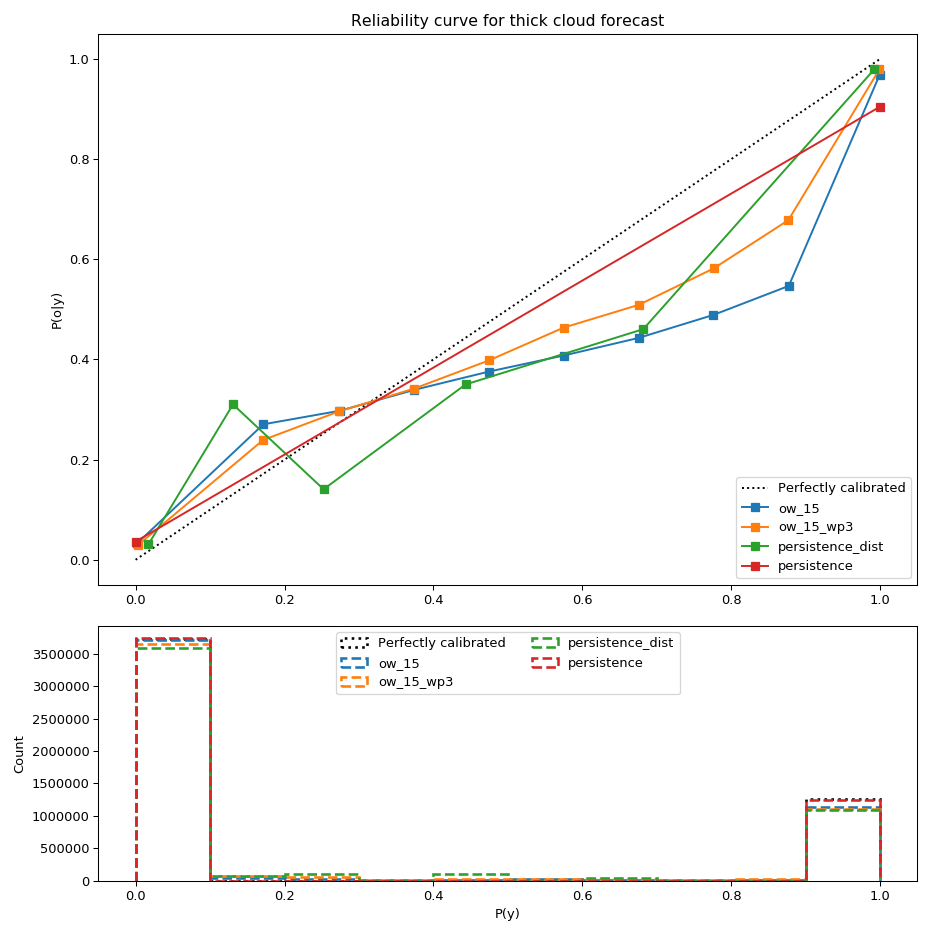

In [120]:
num_of_bins = 10
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.hist(truth_thick.values.ravel(), color='k', linestyle=':', range=(0, 1), bins=num_of_bins, label="Perfectly calibrated",
         histtype="step", lw=2)
for forecast, name in [(ow_15_thick, 'ow_15'),
                       (ow_15_wp3_thick, 'ow_15_wp3'),
                       (persistence_dist_thick, 'persistence_dist'),
                       (persistence_thick, 'persistence')]:
    
    fraction_of_positives, mean_predicted_value = \
        calibration.calibration_curve(
            truth_thick.values.ravel(),
            forecast.values.ravel(), n_bins=num_of_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{name}')
    ax2.hist(forecast.values.ravel(), range=(0, 1), bins=num_of_bins, label=name,
             histtype="step", lw=2, linestyle='--')


ax1.set_ylabel("P(o|y)")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability curve for thick cloud forecast')

ax2.set_xlabel("P(y)")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

# Clear

In [142]:
clear_ub = 0.1

In [143]:
truth_clear = (truth.sel(time=error_times)<clear_ub).astype('float')

In [144]:
persistence_clear = (persistence.sel(time=error_times)<clear_ub).astype('float')

In [145]:
persistence_dist_clear = persistence_clear.copy()

In [146]:
for ii in range(error_times.size):
    persistence_dist_clear[ii] = persistence_dist_clear[ii].mean(dim=['west_east', 'south_north']).item()

In [147]:
ow_15_clear = (ow_15_30.sel(time=error_times)<clear_ub).astype('int')
ow_15_clear = ow_15_clear.mean(dim='ensemble_number')

In [148]:
ow_15_wp3_clear = (ow_15_wp3_30.sel(time=error_times)<clear_ub).astype('int')
ow_15_wp3_clear = ow_15_wp3_clear.mean(dim='ensemble_number')

In [149]:
this = ps.brier_score(truth_clear.values.ravel(), ow_15_wp3_clear.values.ravel()).mean()
print(this)

0.10911937068


In [150]:
this = ps.brier_score(truth_clear.values.ravel(), ow_15_clear.values.ravel()).mean()
print(this)

0.124869352677


In [151]:
this = ps.brier_score(truth_clear.values.ravel(), persistence_dist_clear.values.ravel()).mean()
print(this)

0.126516031713


In [152]:
this = ps.brier_score(truth_clear.values.ravel(), persistence_clear.values.ravel()).mean()
print(this)

0.191029295566


In [153]:
%matplotlib notebook

In [154]:
fraction_of_positives, mean_predicted_value = \
        calibration.calibration_curve(
            truth_clear.values.ravel(),
            ow_15_wp3_clear.values.ravel(), n_bins=num_of_bins)

In [155]:
mean_predicted_value

array([ 0.00942075,  0.17419317,  0.2749678 ,  0.37571841,  0.47602756,
        0.5758863 ,  0.676459  ,  0.77821673,  0.88029054,  0.97469124])

<IPython.core.display.Javascript object>


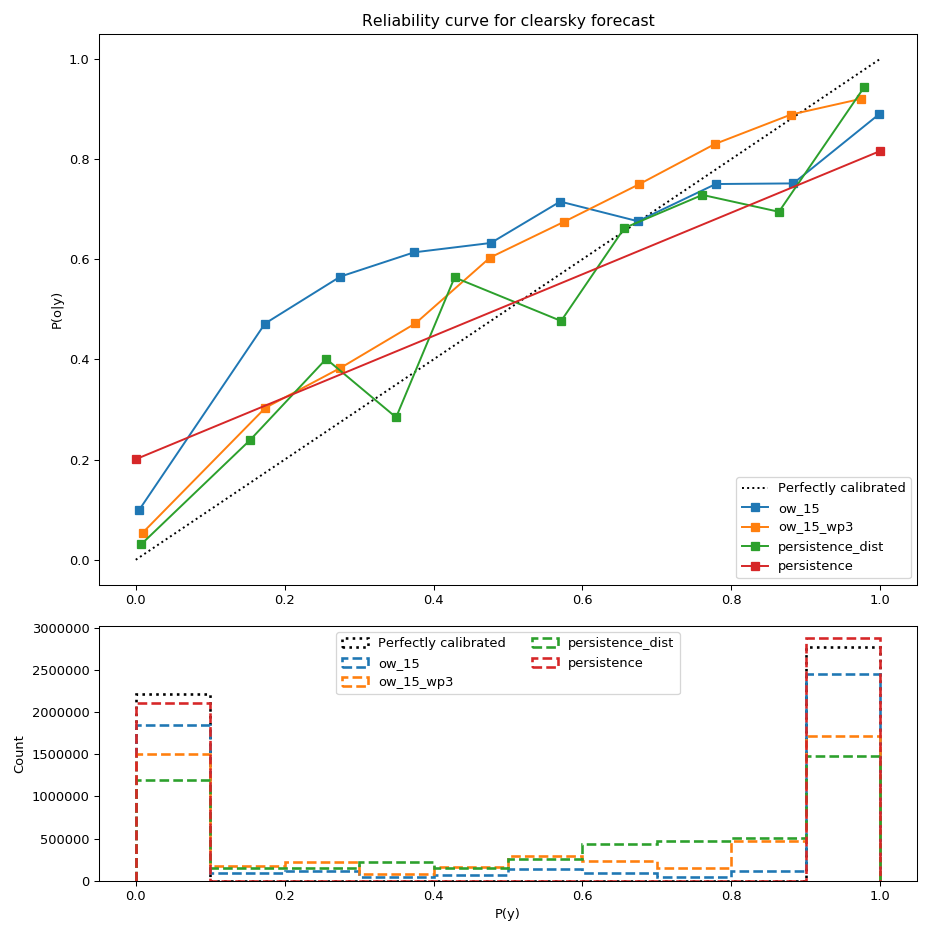

In [156]:
num_of_bins = 10
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.hist(truth_clear.values.ravel(), color='k', linestyle=':', range=(0, 1), bins=num_of_bins, label="Perfectly calibrated",
         histtype="step", lw=2)
for forecast, name in [(ow_15_clear, 'ow_15'),
                       (ow_15_wp3_clear, 'ow_15_wp3'),
                       (persistence_dist_clear, 'persistence_dist'),
                       (persistence_clear, 'persistence')]:
    
    fraction_of_positives, mean_predicted_value = \
        calibration.calibration_curve(
            truth_clear.values.ravel(),
            forecast.values.ravel(), n_bins=num_of_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{name}')
    ax2.hist(forecast.values.ravel(), range=(0, 1), bins=num_of_bins, label=name,
             histtype="step", lw=2, linestyle='--')


ax1.set_ylabel("P(o|y)")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability curve for clearsky forecast')

ax2.set_xlabel("P(y)")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

# Thin cloud

In [170]:
truth_thin = np.logical_and(truth.sel(time=error_times)<thin_ub,
                            truth.sel(time=error_times)>clear_ub).astype('float')

In [171]:
persistence_thin = np.logical_and(persistence.sel(time=error_times)<thin_ub,
                                  persistence.sel(time=error_times)>clear_ub).astype('float')

In [172]:
persistence_dist_thin = persistence_thin.copy()

In [173]:
for ii in range(error_times.size):
    persistence_dist_thin[ii] = persistence_dist_thin[ii].mean(dim=['west_east', 'south_north']).item()

In [174]:
ow_15_thin = np.logical_and(ow_15_30.sel(time=error_times)<thin_ub,
                            ow_15_30.sel(time=error_times)>clear_ub).astype('int')
ow_15_thin = ow_15_thin.mean(dim='ensemble_number')

In [175]:
ow_15_wp3_thin = np.logical_and(ow_15_wp3_30.sel(time=error_times)<thin_ub,
                                ow_15_wp3_30.sel(time=error_times)>clear_ub).astype('int')
ow_15_wp3_thin = ow_15_wp3_thin.mean(dim='ensemble_number')

In [176]:
this = ps.brier_score(truth_thin.values.ravel(), ow_15_wp3_thin.values.ravel()).mean()
print('wp3: ', this)

wp3:  0.114388340785


In [177]:
this = ps.brier_score(truth_thin.values.ravel(), ow_15_thin.values.ravel()).mean()
print('ow_15: ', this)

ow_15:  0.129639324472


In [178]:
this = ps.brier_score(truth_thin.values.ravel(), persistence_dist_thin.values.ravel()).mean()
print(this)

0.113820123612


In [179]:
this = ps.brier_score(truth_thin.values.ravel(), persistence_thin.values.ravel()).mean()
print(this)

0.191175923425


In [180]:
%matplotlib notebook

In [181]:
plt.close('all')

<IPython.core.display.Javascript object>


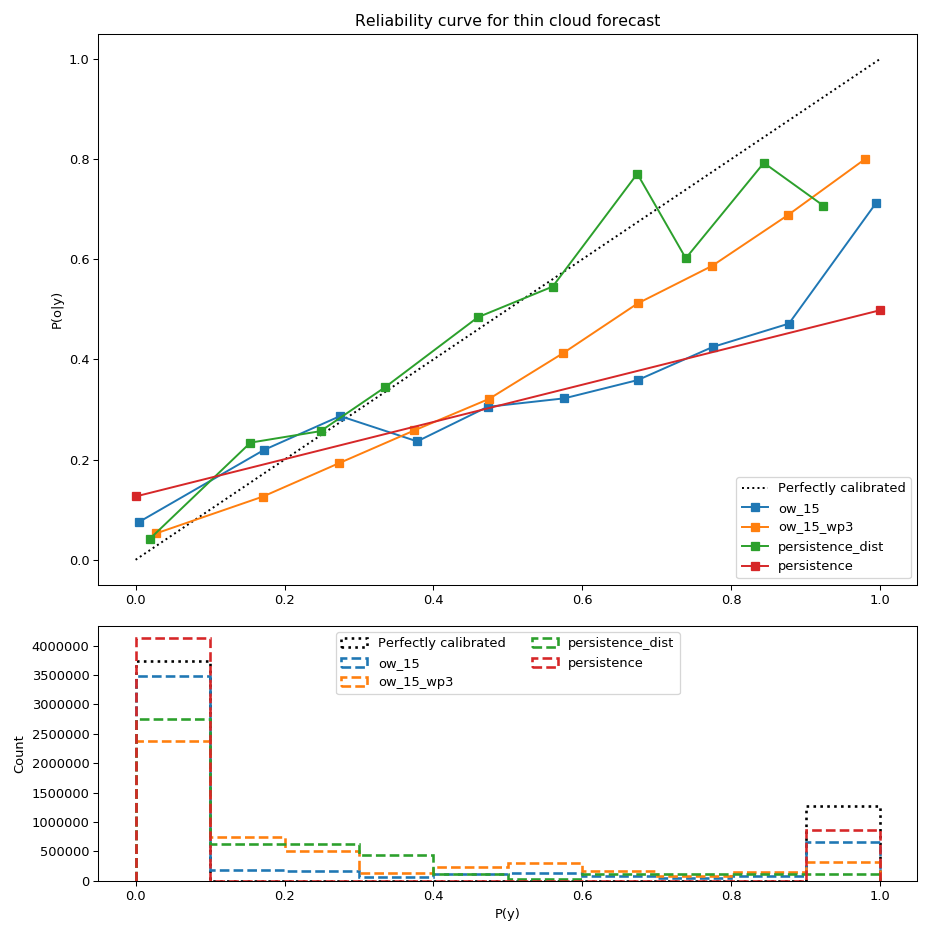

In [182]:
num_of_bins = 10
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.hist(truth_thick.values.ravel(), color='k', linestyle=':', range=(0, 1), bins=num_of_bins, label="Perfectly calibrated",
         histtype="step", lw=2)
for forecast, name in [(ow_15_thin, 'ow_15'),
                       (ow_15_wp3_thin, 'ow_15_wp3'),
                       (persistence_dist_thin, 'persistence_dist'),
                       (persistence_thin, 'persistence')]:
    
    fraction_of_positives, mean_predicted_value = \
        calibration.calibration_curve(
            truth_thin.values.ravel(),
            forecast.values.ravel(), n_bins=num_of_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{name}')
    ax2.hist(forecast.values.ravel(), range=(0, 1), bins=num_of_bins, label=name,
             histtype="step", lw=2, linestyle='--')


ax1.set_ylabel("P(o|y)")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability curve for thin cloud forecast')

ax2.set_xlabel("P(y)")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()